In [1]:
# pip install torch

In [2]:
import abc
import datetime
import lightgbm as lgb
import math
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import optuna.integration.lightgbm as lgbo
import pandas as pd
import plotly.express as px
import seaborn as sns
import sys
import time
import torch
import xgboost as xgb
import warnings

from collections import defaultdict, OrderedDict
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, \
    QuantileTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import auc
from sklearn.mixture import GaussianMixture
from typing import Dict

In [3]:
sns.set()
warnings.filterwarnings('ignore', category=FutureWarning)
le = preprocessing.LabelEncoder()

## Preprocessing

In [4]:
df = pd.read_excel('kaggle_data.xlsx', sheet_name='Dataset')

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [6]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,Price - FTSE 250,Price - FTSE 100,Price - GBP - USD,Price - XLF (financial sector index),Price - EWU,Change % - volatility index,gold price
Date,,,,,,,,,,,,,
2012-12-31,240.245998,243.572501,240.015032,242.463661,176.294033,8654190.0,7958.42,5897.81,1.6253,13.31,35.88,-0.2069,1357.398
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,8115.70,6027.37,1.6256,13.69,36.42,NaN,1367.928
2013-01-03,252.449969,256.346271,250.777993,253.690802,184.457215,30478242.0,8141.06,6047.34,1.6107,13.68,36.10,-0.0082,1356.426


In [7]:
replacing_col = ['Price - FTSE 250', 'Price - FTSE 100', 'Price - GBP - USD',
                 'Price - XLF (financial sector index)', 'Price - EWU', 'gold price']

df[replacing_col] = df[replacing_col].replace(0, np.nan)

In [8]:
for col in replacing_col:
    df[col].fillna((df[col].shift() + df[col].shift(-1)) / 2, inplace=True)

In [9]:
# mask = df.notna().all(axis=1)
mask = df['Close'].notna()

train = df[mask]
test = df[~mask]

In [10]:
train.shape

(2015, 13)

In [11]:
test.shape

(513, 13)

In [12]:
train.head(2)

,Open,High,Low,Close,Adj Close,Volume,Price - FTSE 250,Price - FTSE 100,Price - GBP - USD,Price - XLF (financial sector index),Price - EWU,Change % - volatility index,gold price
Date,,,,,,,,,,,,,
2012-12-31,240.245998,243.572501,240.015032,242.463661,176.294033,8654190.0,7958.42,5897.81,1.6253,13.31,35.88,-0.2069,1357.398
2013-01-03,252.449969,256.346271,250.777993,253.690802,184.457215,30478242.0,8141.06,6047.34,1.6107,13.68,36.10,-0.0082,1356.426


In [13]:
test.head(2)

,Open,High,Low,Close,Adj Close,Volume,Price - FTSE 250,Price - FTSE 100,Price - GBP - USD,Price - XLF (financial sector index),Price - EWU,Change % - volatility index,gold price
Date,,,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,8115.70,6027.37,1.6256,13.69,36.42,NaN,1367.928
2013-01-09,NaN,NaN,NaN,NaN,NaN,NaN,8180.44,6098.65,1.6023,13.75,36.18,NaN,1340.955


## Feature Engineering

In [14]:
feats = test.columns.tolist()
feats

['Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'Price - FTSE 250',
 'Price - FTSE 100',
 'Price - GBP - USD',
 'Price - XLF (financial sector index)',
 'Price - EWU',
 'Change % - volatility index',
 'gold price']

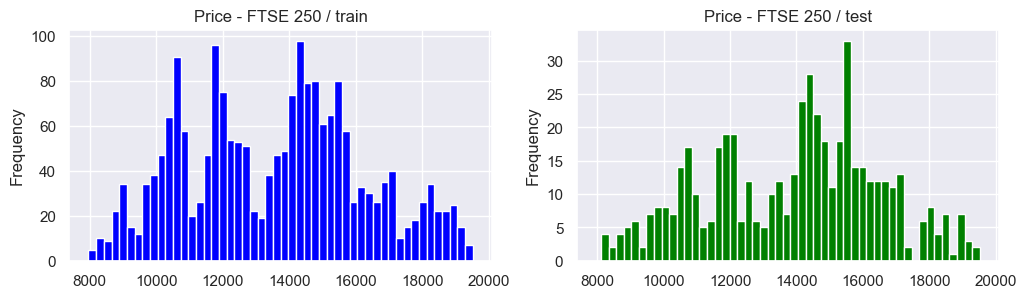

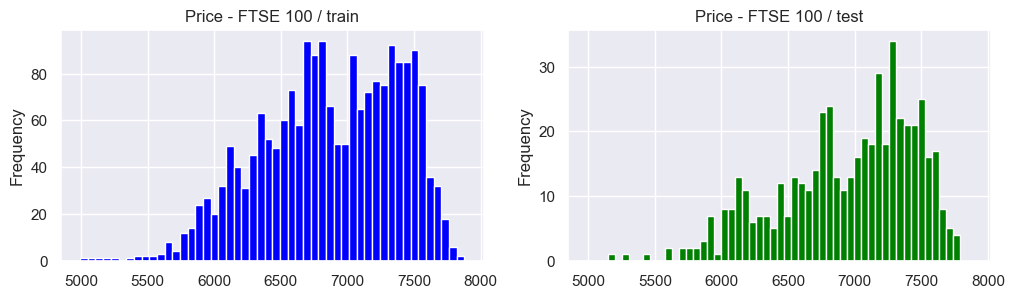

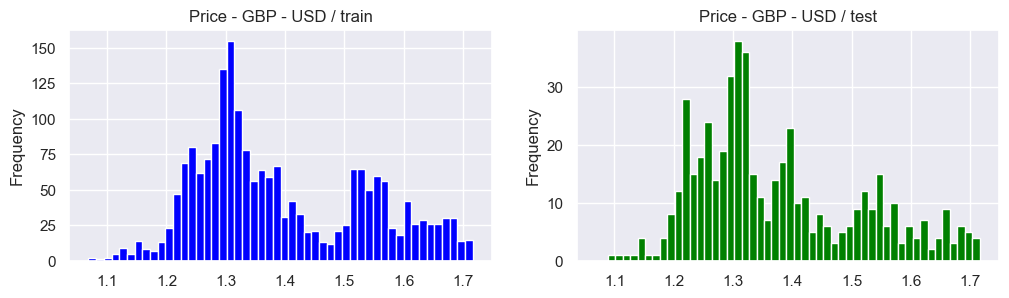

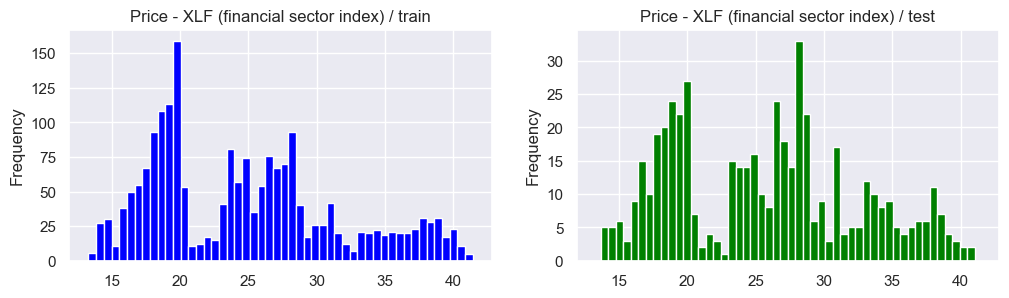

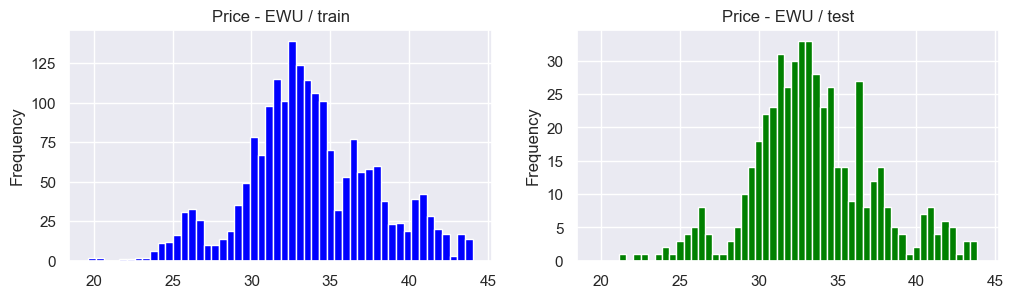

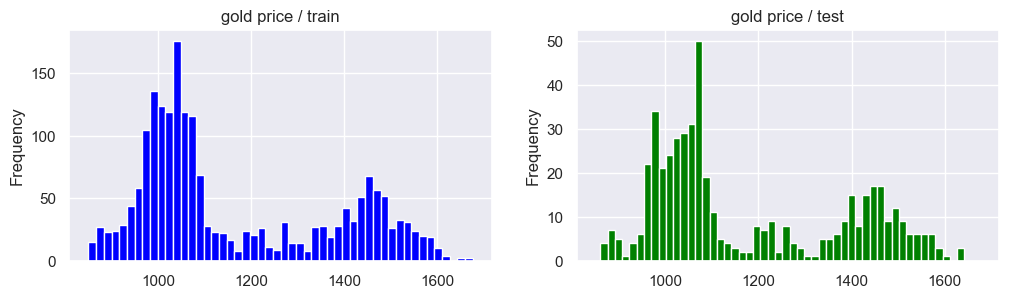

In [15]:
for feat in feats:
    if test[feat].isnull().all():
        continue
    plt.figure(figsize=(12,3))
    ax1 = plt.subplot(1,2,1)
    train[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    ax2 = plt.subplot(1,2,2, sharex=ax1)
    mask = test[feat].notna()
    non_null_values = test[feat][mask]
    non_null_values.plot(kind='hist', bins=50, color='green')
    plt.title(feat + ' / test')
    plt.show()

## Algorithm

In [16]:
class BasicModel(abc.ABC):
    def __init__(self):
        self.best_score=defaultdict(OrderedDict)

    @abc.abstractmethod
    def predict(self, data: np.ndarray)->pd.DataFrame:
        pass

    @abc.abstractmethod
    def train(self, params, valid_sets, train_set, callbacks):
        pass

In [17]:
class XGBoostModel(BasicModel):
    def __init__(self, params):
        super(XGBoostModel, self).__init__()
        self.classifier:xgb.XGBClassifier = xgb.XGBClassifier(**params)
        self.best_score = {"train": {}, "valid": {}}

    def train(self, params, valid_sets, train_set, callbacks, names:Dict={"x":'data', "y":'labels'}, **kwargs):
        x = train_set[names["x"]]
        y = train_set[names["y"]]
        metric = params["metric"]

        eval_sets = []
        for valid_set in valid_sets:

            valid_x = valid_set[names["x"]]
            valid_y = valid_set[names["y"]]
            eval_sets.append([valid_x,valid_y])

        self.classifier.fit(x, y, eval_set=eval_sets, **kwargs)
        self.best_score['valid'][metric]=self.classifier.best_score
        return self
    def predict(self, data: np.ndarray) ->np.ndarray:
        return self.classifier.predict_proba(data)[:, 1]

In [18]:
class XGBoostRegressionModel(BasicModel):
    def __init__(self, params):
        super(XGBoostRegressionModel, self).__init__()
        self.classifier:xgb.XGBRegressor = xgb.XGBRegressor(**params)
        self.best_score = {"train": {}, "valid": {}}

    def train(self, params, valid_sets, train_set, callbacks, names:Dict={"x":'data', "y":'labels'}, **kwargs):
        x = train_set[names["x"]]
        y = train_set[names["y"]]
        metric = params["metric"]

        eval_sets = []
        for valid_set in valid_sets:

            valid_x = valid_set[names["x"]]
            valid_y = valid_set[names["y"]]
            eval_sets.append([valid_x,valid_y])

        self.classifier.fit(x, y, eval_set=eval_sets, **kwargs)
        self.best_score['valid'][metric]=self.classifier.best_score
        return self
    def predict(self, data: np.ndarray) ->np.ndarray:
        return self.classifier.predict(data)

In [19]:
# Pandas setting to display more dataset rows and columns
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [20]:
target_name = "Close"

In [21]:
def show_cm(for_verifi):
    cm = confusion_matrix(train[target_name], np.round(for_verifi))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt=',')
    plt.xlabel('Prediction')
    plt.ylabel('Result')
    plt.show()


def show_roc_curve(X, model, data):
    for_verifi = model.predict(X)
    true = data['Close']
    fpr, tpr, thresholds = roc_curve(true, for_verifi)
    # plt.plot(fpr, tpr, marker='.')
    # plt.xlabel('FPR: False positive rate')
    # plt.ylabel('TPR: True positive rate')
    # plt.title('ROC Curve')
    # plt.show()

    return {'for_verifi': for_verifi,
            'fpr': fpr,
            'tpr': tpr,
            'thresholds': thresholds}

In [22]:
def get_pred(test, feat_test, result_ary):
    fold = []
    print()
    for i in range(len(result_ary)):
        paramObj = result_ary[i]['paramObj']
        model = result_ary[i]['model']
        auc = result_ary[i]['auc']

        print(f'params : {paramObj}')
        print(f'auc : {auc}')
        print()
        result = model.predict(test[feat_test])
        fold.append(result)
    print('-' * 80)
    for f in fold:
        print(f'Result : {f[:10]}...')
    print('-' * 80)
    return fold

In [23]:
def make_xgb_data(test_size, random_state, metric, X, value):
    X_train, X_test, t_train, t_test = train_test_split(
        X,
        value,
        test_size=test_size,
        random_state=random_state
    )

    xgb_train = {
        "data": X_train,
        "labels": t_train
    }
    xgb_test = {
        "data": X_test,
        "labels": t_test
    }

    dic_return = {
        'X_train': X_train,
        'X_test': X_test,
        't_train': t_train,
        't_test': t_test,
        'xgb_train': xgb_train,
        'xgb_eval': xgb_test
    }

    return dic_return

In [24]:
def make_lgb_data(test_size, random_state, metric, X, value):
    X_train, X_test, t_train, t_test = train_test_split(
        X,
        value,
        test_size=test_size,
        random_state=random_state
    )

    lgb_train = lgb.Dataset(
        X_train,
        t_train
    )

    lgb_eval = lgb.Dataset(
        X_test,
        t_test,
        reference=lgb_train
    )

    dic_return = {
        'X_train': X_train,
        'X_test': X_test,
        't_train': t_train,
        't_test': t_test,
        'lgb_train': lgb_train,
        'lgb_eval': lgb_eval
    }

    return dic_return

In [25]:
def make_nn_data(test_size, random_state, metric, X, value):
    X_train, X_test, t_train, t_test = train_test_split(
        X,
        value,
        test_size=test_size,
        random_state=random_state
    )

    X_train = torch.tensor(X_train.to_numpy())
    X_test = torch.tensor(X_test.to_numpy())
    t_train = torch.tensor(t_train.to_numpy())
    t_test = torch.tensor(t_test.to_numpy())

    nn_train = {
        "data": X_train,
        "labels": t_train
    }
    nn_test = {
        "data": X_test,
        "labels": t_test
    }

    dic_return = {
        'X_train': X_train,
        'X_test': X_test,
        't_train': t_train,
        't_test': t_test,
        'nn_train': nn_train,
        'nn_eval': nn_test
    }

    return dic_return

In [26]:
def tuneParams(test_size, random_state, objective, metric, X, value):
    opt_params = {
        "objective": objective,
        "metric": metric
    }

    dic = make_lgb_data(test_size, random_state, metric, X, value)
    lgb_train = dic['lgb_train']
    lgb_eval = dic['lgb_eval']

    opt = lgb.train(
        opt_params,
        lgb_train,
        valid_sets=lgb_eval,
        verbose_eval=False,
        num_boost_round=10,
        early_stopping_rounds=10
    )

    return opt

In [27]:
def make_xgb_model(X, value, test_size, random_state, objective, metric, learning_rate, num_iterations, max_depth,
                   paramObj):
    dic = make_xgb_data(test_size, random_state, metric, X, value)
    xgb_train = dic['xgb_train']
    xgb_eval = dic['xgb_eval']
    X_test = dic['X_test'] 
    t_test = dic['t_test'] 

    xgb_params = {'n_estimators': 1000,
                  'tree_method': 'hist',
                  'metric': metric,
                  'max_depth': 4,
                  'reg_alpha': 0.06790740746476749,
                  'reg_lambda': 0.03393770327994609,
                  'min_child_weight': 1,
                  'gamma': 2.5705812096617772e-05,
                  'learning_rate': 0.07132617944894756,
                  'colsample_bytree': 0.11664298814833247,
                  'colsample_bynode': 0.9912092923877247,
                  'colsample_bylevel': 0.29178614622079735,
                  'subsample': 0.7395301853144935,
                  'random_state': 42,
                  'early_stopping_rounds': 20
                  }

    evaluation_results = {}
    xgbm = XGBoostRegressionModel(xgb_params)
    model = xgbm.train(
        xgb_params,
        names={"x": 'data', "y": 'labels'},
        valid_sets=[xgb_train, xgb_eval],
        train_set=xgb_train,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, ),
            lgb.record_evaluation(evaluation_results),
            lgb.log_evaluation(100)
        ]
    )

    resultObj = {'paramObj': paramObj,
                 'evaluation_results': evaluation_results,
                 'model': model,
                 'X_test': X_test, 
                 't_test': t_test} 
    return resultObj

In [28]:
def make_lgb_model(X, value, test_size, random_state, objective, metric, learning_rate, num_iterations, max_depth,
                   paramObj):
    dic = make_lgb_data(test_size, random_state, metric, X, value)
    lgb_train = dic['lgb_train']
    lgb_eval = dic['lgb_eval']
    X_test = dic['X_test'] 
    t_test = dic['t_test'] 

    params = {
        'task': 'train',
        'objective': objective,
        'metric': metric,
        'boosting_type': 'gbdt',
        'learning_rate': learning_rate,
        'num_iterations': num_iterations,
        'max_depth': max_depth,
        'feature_pre_filter': paramObj['feature_pre_filter'],
        'lambda_l1': paramObj['lambda_l1'],
        'lambda_l2': paramObj['lambda_l2'],
        'num_leaves': paramObj['num_leaves'],
        'feature_fraction': paramObj['feature_fraction'],
        'bagging_fraction': paramObj['bagging_fraction'],
        'bagging_freq': paramObj['bagging_freq'],
        'min_child_samples': paramObj['min_child_samples'],
        'verbosity': -1
    }

    evaluation_results = {}
    model = lgb.train(
        params,
        valid_names=['train', 'valid'],
        valid_sets=[lgb_train, lgb_eval],
        train_set=lgb_train,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, ),
            lgb.record_evaluation(evaluation_results),
            lgb.log_evaluation(100)
        ]
    )

    resultObj = {'paramObj': paramObj,
                 'evaluation_results': evaluation_results,
                 'model': model,
                 'X_test': X_test,
                 't_test': t_test}
    return resultObj

In [29]:
def make_nn_model(X, value, test_size, random_state, objective, metric, learning_rate, num_iterations, max_depth,
                  paramObj):
    dic = make_nn_data(test_size, random_state, metric, X, value)
    nn_train = dic['nn_train']
    nn_eval = dic['nn_eval']
    X_test = dic['X_test']
    t_test = dic['t_test']

    params = {
        'task': 'train',
        'objective': objective,
        'metric': metric,
        'learning_rate': learning_rate,
        'num_iterations': num_iterations,
        'max_depth': max_depth,
        'lambda_l1': paramObj['lambda_l1'],
        'lambda_l2': paramObj['lambda_l2'],
    }

    evaluation_results = {}
    model = NNModel()
    model = model.train(
        params,
        names={"x": 'data', "y": 'labels'},
        valid_sets=[nn_eval],
        train_set=nn_train,
        callbacks=[
            lgb.early_stopping(stopping_rounds=100, ),
            lgb.record_evaluation(evaluation_results),
            lgb.log_evaluation(100)
        ]
    )

    resultObj = {'paramObj': paramObj,
                 'evaluation_results': evaluation_results,
                 'model': model,
                 'X_test': X_test,
                 't_test': t_test} 
    return resultObj

In [30]:
def get_gmm_class_feature(feat, n, train, test, feat_test_extended):
    gmm = GaussianMixture(n_components=n, random_state=42)
    gmm.fit(train[feat].values.reshape(-1, 1))
    train[f'{feat}_class'] = gmm.predict(train[feat].values.reshape(-1, 1))
    test[f'{feat}_class'] = gmm.predict(test[feat].values.reshape(-1, 1))
    feat_test_extended.append(f'{feat}_class')

In [31]:
feat_train =[target_name, 'Price - FTSE 250', 'Price - FTSE 100', 'Price - GBP - USD',
                 'Price - XLF (financial sector index)', 'Price - EWU', 'gold price']
feat_test = ['Price - FTSE 250', 'Price - FTSE 100', 'Price - GBP - USD',
                 'Price - XLF (financial sector index)', 'Price - EWU', 'gold price']
feat_test_extended = feat_test.copy()

In [32]:
train['mean'] = train[feat_test].mean(axis=1)
train['std'] = train[feat_test].std(axis=1)
test['mean'] = test[feat_test].mean(axis=1)
test['std'] = test[feat_test].std(axis=1)

feat_test_extended += ['mean', 'std']

/var/folders/js/m5qnfp1x15x0yvglhtdhp_cm0000gn/T/ipykernel_50153/3047553470.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['mean'] = train[feat_test].mean(axis=1)
/var/folders/js/m5qnfp1x15x0yvglhtdhp_cm0000gn/T/ipykernel_50153/3047553470.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['std'] = train[feat_test].std(axis=1)
/var/folders/js/m5qnfp1x15x0yvglhtdhp_cm0000gn/T/ipykernel_50153/3047553470.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

In [33]:
# ----------------------------------------------------
# Base setting
# ----------------------------------------------------
test_size = 0.25
random_state = 0
objective = 'regression'
metric = 'rmse'  # binary_logloss, binary_error, auc

# ----------------------------------------------------
# for optuna
# ----------------------------------------------------
optuna_switch = 'off'
opt_count = 1
num_choose = 1

if opt_count < num_choose:
    num_choose = opt_count

# ----------------------------------------------------
# for lightGBM
# ----------------------------------------------------
learning_rate = 0.005  # 0.0001
num_iterations = 300000  # 100
max_depth = -1

X = train[feat_test_extended]
value = train[target_name]

# optuna

if optuna_switch == 'on':
    param_ary = []
    for i in range(opt_count):
        print('=' * 80)
        print(f'【Round : {i + 1}】')
        print('=' * 80)
        opt = tuneParams(test_size, random_state, objective, metric, X, value)
        score = opt.best_score['valid_0'][metric]
        dic = {'score': score, 'params': opt.params}
        param_ary.append(dic)

    if metric == 'auc':
        param_ary = sorted(param_ary, key=lambda x: x['score'], reverse=True)
    elif metric == 'binary_logloss':
        param_ary = sorted(param_ary, key=lambda x: x['score'], reverse=False)

if optuna_switch == 'on':
    count = 0
    for dic in param_ary:
        score = dic['score']
        params = dic['params']
        count += 1
        print('')
        print('=' * 100)
        print(f'【Place : {count}】')
        print(f'opt_score : {score}')
        print(f'params : {params}')
        print('=' * 100)
        print('')

if optuna_switch == 'on':
    param_ary = param_ary[0: num_choose]
else:
    # In case of unusing optuna, set params here
    param_ary = [
        {'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False,
         'lambda_l1': 1.6314697848556082e-05, 'lambda_l2': 9.531962710059137e-05, 'num_leaves': 85,
         'feature_fraction': 1.0, 'bagging_fraction': 0.9991169270666491, 'bagging_freq': 6, 'min_child_samples': 50,
         'num_iterations': 10, 'early_stopping_round': None, 'boosting': 'gbdt'}
    ]

result_ary = []

for i in range(len(param_ary)):
    print()
    print('=' * 80)
    print(f'【Round : {i + 1}】')

    if optuna_switch == 'on':
        score = param_ary[i]['score']
        print(f'opt score : {score}')
        paramObj = param_ary[i]['params']
    else:
        paramObj = param_ary[i]

    print(f'params : {paramObj}')
    print('-' * 80)
    resultObj = make_lgb_model(X, value, test_size, random_state, objective, metric, learning_rate, num_iterations,
                               max_depth, paramObj)
    result_ary.append(resultObj)

for i in range(len(param_ary)):
    print()
    print('=' * 80)
    print(f'【Round : {i + 1}】')

    if optuna_switch == 'on':
        score = param_ary[i]['score']
        print(f'opt score : {score}')
        paramObj = param_ary[i]['params']
    else:
        paramObj = param_ary[i]

    print(f'params : {paramObj}')
    print('-' * 80)
    resultObj = make_xgb_model(X, value, test_size, random_state, objective, metric, learning_rate, num_iterations,
                               max_depth, paramObj)
    result_ary.append(resultObj)

# Confusion matrix

for i in range(len(result_ary)):
    print('-' * 80)
    print(f'Round {i + 1} / {len(result_ary)}')
    model = result_ary[i]['model']
    val_score = model.best_score['valid'][metric]
    print(f'Valid Score : {val_score}')
    print('-' * 80)

    # Rock curve
    # obj = show_roc_curve(X, model, train)

    for_verifi = model.predict(X)
    true = train['Close']
    mae = ((for_verifi-true).abs() / for_verifi).mean()

    result_ary[i]['auc'] = mae 
    print(f'mae : {mae}')
    print()


# Predict with learned model


fold = get_pred(test, feat_test_extended, result_ary)

# # Ensemble predicted results

df_result = pd.DataFrame(fold).transpose().mean(axis=1)

/usr/local/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")



【Round : 1】
params : {'objective': 'regression', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 1.6314697848556082e-05, 'lambda_l2': 9.531962710059137e-05, 'num_leaves': 85, 'feature_fraction': 1.0, 'bagging_fraction': 0.9991169270666491, 'bagging_freq': 6, 'min_child_samples': 50, 'num_iterations': 10, 'early_stopping_round': None, 'boosting': 'gbdt'}
--------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 30.792	valid's rmse: 32.0528
[200]	train's rmse: 20.407	valid's rmse: 21.4822
[300]	train's rmse: 14.3589	valid's rmse: 15.3904
[400]	train's rmse: 11.043	valid's rmse: 12.0936
[500]	train's rmse: 9.30361	valid's rmse: 10.4367
[600]	train's rmse: 8.33864	valid's rmse: 9.55891
[700]	train's rmse: 7.78255	valid's rmse: 9.07126
[800]	train's rmse: 7.41479	valid's rmse: 8.77053
[900]	train's rmse: 7.15779	valid's rmse: 8.57961
[1000]	train's rmse: 6.94218	valid's rmse

/usr/local/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:49:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "metric" } are not used.

  warnings.warn(smsg, UserWarning)


[36]	validation_0-rmse:23.10902	validation_1-rmse:23.98765
[37]	validation_0-rmse:22.82364	validation_1-rmse:23.76152
[38]	validation_0-rmse:22.74629	validation_1-rmse:23.71563
[39]	validation_0-rmse:22.61795	validation_1-rmse:23.61654
[40]	validation_0-rmse:22.22260	validation_1-rmse:23.20934
[41]	validation_0-rmse:22.02493	validation_1-rmse:23.00226
[42]	validation_0-rmse:21.68604	validation_1-rmse:22.67054
[43]	validation_0-rmse:21.59409	validation_1-rmse:22.60354
[44]	validation_0-rmse:21.53947	validation_1-rmse:22.55070
[45]	validation_0-rmse:21.38143	validation_1-rmse:22.42081
[46]	validation_0-rmse:21.11985	validation_1-rmse:22.21184
[47]	validation_0-rmse:20.99111	validation_1-rmse:22.14746
[48]	validation_0-rmse:20.84137	validation_1-rmse:21.97564
[49]	validation_0-rmse:20.73443	validation_1-rmse:21.90648
[50]	validation_0-rmse:20.17971	validation_1-rmse:21.31946
[51]	validation_0-rmse:19.97090	validation_1-rmse:21.14850
[52]	validation_0-rmse:19.73308	validation_1-rmse:20.900

[174]	validation_0-rmse:11.30756	validation_1-rmse:14.69320
[175]	validation_0-rmse:11.28896	validation_1-rmse:14.67254
[176]	validation_0-rmse:11.27011	validation_1-rmse:14.66219
[177]	validation_0-rmse:11.22962	validation_1-rmse:14.63273
[178]	validation_0-rmse:11.19571	validation_1-rmse:14.60421
[179]	validation_0-rmse:11.17826	validation_1-rmse:14.58500
[180]	validation_0-rmse:11.16315	validation_1-rmse:14.58816
[181]	validation_0-rmse:11.14483	validation_1-rmse:14.59945
[182]	validation_0-rmse:11.13081	validation_1-rmse:14.60885
[183]	validation_0-rmse:11.12078	validation_1-rmse:14.59493
[184]	validation_0-rmse:11.10282	validation_1-rmse:14.59644
[185]	validation_0-rmse:11.08747	validation_1-rmse:14.59976
[186]	validation_0-rmse:11.06788	validation_1-rmse:14.60321
[187]	validation_0-rmse:11.04456	validation_1-rmse:14.61827
[188]	validation_0-rmse:11.02383	validation_1-rmse:14.63493
[189]	validation_0-rmse:10.98564	validation_1-rmse:14.61238
[190]	validation_0-rmse:10.95810	validat

[312]	validation_0-rmse:8.93990	validation_1-rmse:13.82191
[313]	validation_0-rmse:8.92209	validation_1-rmse:13.79850
[314]	validation_0-rmse:8.90475	validation_1-rmse:13.78779
[315]	validation_0-rmse:8.88950	validation_1-rmse:13.79873
[316]	validation_0-rmse:8.88311	validation_1-rmse:13.81763
[317]	validation_0-rmse:8.86499	validation_1-rmse:13.78978
[318]	validation_0-rmse:8.86086	validation_1-rmse:13.78975
[319]	validation_0-rmse:8.85084	validation_1-rmse:13.79816
[320]	validation_0-rmse:8.83330	validation_1-rmse:13.78202
[321]	validation_0-rmse:8.82390	validation_1-rmse:13.78690
[322]	validation_0-rmse:8.81166	validation_1-rmse:13.78181
[323]	validation_0-rmse:8.80326	validation_1-rmse:13.77293
[324]	validation_0-rmse:8.78739	validation_1-rmse:13.76215
[325]	validation_0-rmse:8.77756	validation_1-rmse:13.76725
[326]	validation_0-rmse:8.77233	validation_1-rmse:13.76182
[327]	validation_0-rmse:8.76019	validation_1-rmse:13.76526
[328]	validation_0-rmse:8.75572	validation_1-rmse:13.770

[451]	validation_0-rmse:7.75088	validation_1-rmse:13.53459
[452]	validation_0-rmse:7.74397	validation_1-rmse:13.53699
[453]	validation_0-rmse:7.73844	validation_1-rmse:13.53330
[454]	validation_0-rmse:7.73020	validation_1-rmse:13.53329
[455]	validation_0-rmse:7.72469	validation_1-rmse:13.52513
[456]	validation_0-rmse:7.71968	validation_1-rmse:13.51832
[457]	validation_0-rmse:7.71746	validation_1-rmse:13.51409
[458]	validation_0-rmse:7.71272	validation_1-rmse:13.51348
[459]	validation_0-rmse:7.70862	validation_1-rmse:13.51640
[460]	validation_0-rmse:7.70031	validation_1-rmse:13.51846
[461]	validation_0-rmse:7.68935	validation_1-rmse:13.52502
[462]	validation_0-rmse:7.68281	validation_1-rmse:13.52276
[463]	validation_0-rmse:7.67994	validation_1-rmse:13.52499
[464]	validation_0-rmse:7.67662	validation_1-rmse:13.53343
[465]	validation_0-rmse:7.67327	validation_1-rmse:13.54006
[466]	validation_0-rmse:7.67221	validation_1-rmse:13.52361
[467]	validation_0-rmse:7.67116	validation_1-rmse:13.519

## Submission

In [34]:
export_df = pd.DataFrame(columns=['Date', 'Closing price'])

test_dates = list(test.index)
formatted_dates = []
for date in test_dates:
    formatted = date.strftime('%Y%m%d')
    formatted_dates.append(formatted)

In [35]:
export_df['Date'] = formatted_dates
export_df['Closing price'] = list(df_result)
export_df

,Date,Closing price
0,20130102,263.20540
1,20130109,265.37579
2,20130110,267.62852
3,20130115,262.90915
4,20130121,270.19193
...,...,...
508,20221129,158.69799
509,20221130,164.78921
510,20221202,162.91610
511,20221206,162.82940


In [36]:
# export_df.to_excel('predicted.xlsx', index=False)

## Output Validation

![](output_gradientBoosting.jpg) 